In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import pathlib
from typing import List, Tuple
import uproot3

In [2]:
import matplotlib

font = {'size'   : 14}

#matplotlib.rc('font', **font)

In [3]:
## 'recov' for recovered events only
## 'nonconv for all non-converging events (which can be recovered by ignoring VF failure)
dataset = 'nonconv'

In [4]:
if dataset == 'recov':
    input_file = '/scratch/user/adegenna/top50_xyz_seq/Lb2JPsiL_Run2_Sim_2016_MagUp_v12_VertexingDebug.root'
    fn_prefix = 'RECOVERED_'
    vf_series_label = 'Standard reconstructed'
    non_vf_series_label = 'Recovered'
elif dataset == 'nonconv':
    input_file = '/scratch/user/adegenna/top50_accept_all_no_debug/Lb2JPsiL_Run2_Sim_2016_MagUp_v12_VertexingDebug.root'
    fn_prefix = 'NONCONVERGED_'
    vf_series_label = 'Converged'
    non_vf_series_label = 'Non-converged'
else:
    raise ValueError

In [5]:
save_plots = True
black_and_white = False
show_titles = False
thick_hist_lines = False

## Pick what extra branches you want
with_dtf = True
with_pidsubs = False
with_protoparticles = True
with_2Ddebug = True
with_truevtx_kinematics = True

## Perform analysis with:
## - All data: 'b' (both)
## - Only Lambdas: 'm' (matter)
## - Only antiLambdas: 'a' (antimatter)
use_matter_antimatter = 'b'

## Choose colors
color_gen = 'tab:gray'
color_3D = 'tab:blue'
color_2D = 'tab:orange'

truth_match = False ## Failed attempt at truth matching, not needed

In [6]:
if use_matter_antimatter == 'b':
    if dataset == 'recov':
        event_category_label = 'All reconstructed events'
        recovered_label = 'All recovered events'
    else:
        event_category_label = 'All recoverable events'
        recovered_label = 'All non-converged events'
    proton_symbol = 'p'
    pion_symbol = '\pi'
    file_suffix = ''
elif use_matter_antimatter == 'm':
    if dataset == 'recov':
        event_category_label = 'Only $\Lambda^0$ events'
        recovered_label = 'Only $\Lambda^0$ recovered events'
    else:
        event_category_label = 'Only $\Lambda^0$ recoverable events'
        recovered_label = 'Only $\Lambda^0$ non-converged events'
    proton_symbol = 'p'
    pion_symbol = '\pi^-'
    file_suffix = '_matter'
elif use_matter_antimatter == 'a':
    if dataset == 'recov':
        event_category_label = r'Only $\bar{\Lambda}^0$ events'
        recovered_label = r'Only $\bar{\Lambda}^0$ recovered events'
    else:
        event_category_label = r'Only $\bar{\Lambda}^0$ recoverable events'
        recovered_label = r'Only $\bar{\Lambda}^0$ non-converged events'
    proton_symbol = r'\bar{p}'
    pion_symbol = '\pi^+'
    file_suffix = '_antimatter'
else:
    raise ValueError

In [7]:
## Create plots directory, if missing
plots_dir = (str(pathlib.Path.home())
                  + '/vertex-reconstruction-studies/'
                  + 'plots/'
                  + 'C_studies_on_integrated_root_files/'
                  + 'residuals_at_true_vertex_analysis/'
)
pathlib.Path(plots_dir).mkdir(parents=True, exist_ok=True)

# Import data (v2.1)

In [8]:
def root_file_to_df(
    filename: str,
    branches_ordinary: List[str] = [],
    branches_jagged: List[str] = [],   ## These are the protoparticles, really
    truth_tree: bool = False,
    slice_ordinary: bool = True
) -> pd.DataFrame:
    if len(branches_jagged) == 0:
        have_jagged = False
    else:
        have_jagged = True
    
    if len(branches_ordinary) == 0:
        have_ordinary = False
    else:
        have_ordinary = True
    
    with uproot3.open(filename) as file_root:
        if truth_tree:
            tree = file_root['Lb_MC/MCDecayTree']
        else:
            tree = file_root['Lb_T/DecayTree']
        ## Load dataFrame with desired branches
        if have_ordinary:
            if slice_ordinary:
                df_ord = tree.pandas.df(branches_ordinary).loc[(slice(None), 0), :]
            else:
                df_ord = tree.pandas.df(branches_ordinary)
        if have_jagged:
            df_jag = tree.pandas.df(branches_jagged, flatten=False)
            for col in list(df_jag):
                df_jag[col] = df_jag[col].str[0]
        
        if have_ordinary and not have_jagged:
            df = df_ord
        elif not have_ordinary and have_jagged:
            df = df_jag
        elif have_ordinary and have_jagged:
            df = pd.merge(df_ord, df_jag, left_index=True, right_index=True)
            if len(df) != len(df_jag):
                raise ValueError
        else:
            raise ValueError
            
        ## Reset indices
        df.reset_index(drop=True, inplace=True)
        return df

## Reco
### Choose branches

In [9]:
composite_particles = ['Lb', 'L', 'Jpsi']
basic_particles = ['p', 'pim', 'mum', 'mup']
lambda_baryons = ['L', 'Lb']

lambdab_daughters = ['L', 'Jpsi']
lambdab_daughters_DTF = ['Lambda0', 'J_psi_1S']

lambdab_nephews = {
    'L': ['p', 'pim'],
    'Jpsi': ['mum', 'mup'],
}
lambdab_nephews_DTF = {
    'Lambda0': ['pplus', 'piplus'],
    'J_psi_1S': ['muminus_0', 'muminus'],
}

DTF_mass_constraints = ['FixJPsi', 'FixJPsiLambda']

#### Original names

In [10]:
## Reco branches
reco_branches = []
for prefix in composite_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches.append(prefix + '_ENDVERTEX_' + component)
    reco_branches.append(prefix + '_M')
    reco_branches.append(prefix + '_MM')
        
for prefix in composite_particles + basic_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches.append(prefix + '_P' + component)
    reco_branches.append(prefix + '_ID')    
    
for prefix in lambda_baryons:
    reco_branches.append(prefix + '_BPVDIRA')
    reco_branches.append(prefix + '_BPVIPCHI2')
    reco_branches.append(prefix + '_BPVVDCHI2')
    reco_branches.append(prefix + '_VFASPF_CHI2_VDOF')
    
for feature in ['X', 'Y', 'Z', 'CHI2', 'NDOF']:
    reco_branches.append('Lb_OWNPV_' + feature)

reco_branches.append('Polarity')

## Truth branches
truth_branches = []

for prefix in lambda_baryons:
    for component in ['X', 'Y', 'Z']:
        truth_branches.append(prefix + '_TRUEENDVERTEX_' + component)
        
for prefix in basic_particles:
    for component in ['X', 'Y', 'Z']:
        truth_branches.append(prefix + '_TRUEP_' + component)

truth_branches.append('L_TRUEID')
truth_branches.append('Lb_TRUEID')
        
for prefix in basic_particles + composite_particles:
    truth_branches.append(prefix + '_Reconstructible')
    truth_branches.append(prefix + '_Reconstructed')

## DTF branches
dtf_branches = []
if with_dtf:
    for mass_constraint in DTF_mass_constraints:
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_status')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_M')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_P')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_chi2')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_PV_' + feature)

        for mother in lambdab_daughters_DTF:
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_M')
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_P')
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews_DTF[mother]:
                for component in ['X', 'Y', 'Z']:
                    dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_' + daughter + '_P' + component)

## PIDsubs branches
pidsubs_branches = []
if with_pidsubs:
    for mass_constraint in DTF_mass_constraints:
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_status')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_M')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_P')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_chi2')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_PV_' + feature)

        for mother in lambdab_daughters_DTF:
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_M')
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_P')
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews_DTF[mother]:
                for component in ['X', 'Y', 'Z']:
                    pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_' + daughter + '_P' + component)
                    
    pidsubs_branches.append('TrackType')

## Protoparticle branches
pp_branches = []
if with_protoparticles:
    for part in ['p', 'pim']:
        for feature in ['', 'P']:
            for comp in ['X', 'Y', 'Z']:
                pp_branches.append(part + '_PP_' + feature + comp)
        
        pmc_components = [0, 1, 3, 4, 5] ## 2 is z, all zeros
        
        for row in pmc_components:
            for column in [c for c in pmc_components if c >= row]:
                pp_branches.append(part + '_PP_POSMOMCOV' + '_' +  str(row) +  '_' + str(column))
                
## 2D debug branches
debug_branches = []
if with_2Ddebug:
    debug_branches.append('L_ENDVERTEX_XERR')
    debug_branches.append('L_ENDVERTEX_YERR')
    debug_branches.append('L_ENDVERTEX_ZERR')
    debug_branches.append('L_ALGO_ID')
    
## True vertex kinematics
truevtxkin_branches = []
if with_truevtx_kinematics:
    for kinematic_computation_point in ['AtTrueVtx', 'AtFirstMeas']:
        for prefix in ['p', 'pim']:
            ## Actually no need for z, it's fixed by the transporter
            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches.append(prefix + '_' + kinematic_computation_point + '_REFP_' + component)
                truevtxkin_branches.append(prefix + '_' + kinematic_computation_point + '_REFP_' + component + "ERR")

            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches.append(prefix + '_' + kinematic_computation_point + '_P_' + component)
                truevtxkin_branches.append(prefix + '_' + kinematic_computation_point + '_P_' + component + "ERR")
                
            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches.append('MCTRUTH_' + prefix + '_' + kinematic_computation_point + '_REFP_' + component)
                truevtxkin_branches.append('MCTRUTH_' + prefix + '_' + kinematic_computation_point + '_REFP_' + component + "ERR")

            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches.append('MCTRUTH_' + prefix + '_' + kinematic_computation_point + '_P_' + component)
                truevtxkin_branches.append('MCTRUTH_' + prefix + '_' + kinematic_computation_point + '_P_' + component + "ERR")
    
branches = (
    reco_branches + truth_branches
    + dtf_branches + pidsubs_branches
    + debug_branches + truevtxkin_branches
)

branches_jagged = pp_branches

#### New names

In [11]:
## Reco branches
reco_branches_renamed = []
for prefix in composite_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches_renamed.append(prefix + '_ENDVERTEX_' + component)
    reco_branches_renamed.append(prefix + '_M')
    reco_branches_renamed.append(prefix + '_MM')
        
for prefix in composite_particles + basic_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches_renamed.append(prefix + '_P' + component)
    reco_branches_renamed.append(prefix + '_ID')    
    
for prefix in lambda_baryons:
    reco_branches_renamed.append(prefix + '_BPVDIRA')
    reco_branches_renamed.append(prefix + '_BPVIPCHI2')
    reco_branches_renamed.append(prefix + '_BPVVDCHI2')
    reco_branches_renamed.append(prefix + '_VFASPF_CHI2_VDOF')
    
for feature in ['X', 'Y', 'Z', 'CHI2', 'NDOF']:
    reco_branches_renamed.append('Lb_OWNPV_' + feature)

reco_branches_renamed.append('Polarity')

## Truth branches
truth_branches_renamed = []

for prefix in lambda_baryons:
    for component in ['X', 'Y', 'Z']:
        truth_branches_renamed.append('MCTRUTH_' + prefix + '_ENDVERTEX_' + component)
        
for prefix in basic_particles:
    for component in ['X', 'Y', 'Z']:
        truth_branches_renamed.append('MCTRUTH_' + prefix + '_P' + component)

truth_branches_renamed.append('MCTRUTH_L_ID')
truth_branches_renamed.append('MCTRUTH_Lb_ID')
        
for prefix in basic_particles + composite_particles:
    truth_branches_renamed.append('MCTRUTH_' + prefix + '_Reconstructible')
    truth_branches_renamed.append('MCTRUTH_' + prefix + '_Reconstructed')

## DTF branches
dtf_branches_renamed = []
if with_dtf:
    for mass_constraint in DTF_mass_constraints:
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_status')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_Lb_M')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_Lb_P')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_chi2')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            dtf_branches_renamed.append('Lb_DTF_' + mass_constraint + '_PV_' + feature)

        for mother in lambdab_daughters:
            dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + mother + '_M')
            dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + mother + '_P')
            dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews[mother]:
                for component in ['X', 'Y', 'Z']:
                    dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + daughter + '_P' + component)

## PIDsubs branches
pidsubs_branches_renamed = []
if with_pidsubs:
    for mass_constraint in DTF_mass_constraints:
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_status')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_Lb_M')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_Lb_P')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_chi2')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_PV_' + feature)

        for mother in lambdab_daughters:
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_M')
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_P')
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews[mother]:
                for component in ['X', 'Y', 'Z']:
                    pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + daughter + '_P' + component)
                    
    pidsubs_branches_renamed.append('TrackType')

## Protoparticle branches
pp_branches_renamed = []
if with_protoparticles:
    for part in ['p', 'pim']:
        for feature in ['', 'P']:
            for comp in ['X', 'Y', 'Z']:
                pp_branches_renamed.append(part + '_PP_' + feature + comp)
        
        pmc_components = [0, 1, 3, 4, 5] ## 2 is z, all zeros
        
        for row in pmc_components:
            for column in [c for c in pmc_components if c >= row]:
                pp_branches_renamed.append(part + '_PP_POSMOMCOV' + '_' +  str(row) +  '_' + str(column))
                
## 2D debug branches
debug_branches_renamed = []
if with_2Ddebug:
    debug_branches_renamed.append('L_ENDVERTEX_XERR')
    debug_branches_renamed.append('L_ENDVERTEX_YERR')
    debug_branches_renamed.append('L_ENDVERTEX_ZERR')
    debug_branches_renamed.append('L_ALGO_ID')

## True vertex kinematics
truevtxkin_branches_renamed = []
if with_truevtx_kinematics:
    for kinematic_computation_point in ['AtTrueVtx', 'AtFirstMeas']:
        for prefix in ['p', 'pim']:
            ## Actually no need for z, it's fixed by the transporter
            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches_renamed.append(prefix + '_' + kinematic_computation_point + '_REFP_' + component)
                truevtxkin_branches_renamed.append(prefix + '_' + kinematic_computation_point + '_REFP_' + component + "ERR")

            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches_renamed.append(prefix + '_' + kinematic_computation_point + '_P_' + component)
                truevtxkin_branches_renamed.append(prefix + '_' + kinematic_computation_point + '_P_' + component + "ERR")
    
            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches_renamed.append('MCTRUTH_' + prefix + '_' + kinematic_computation_point + '_REFP_' + component)
                truevtxkin_branches_renamed.append('MCTRUTH_' + prefix + '_' + kinematic_computation_point + '_REFP_' + component + "ERR")

            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches_renamed.append('MCTRUTH_' + prefix + '_' + kinematic_computation_point + '_P_' + component)
                truevtxkin_branches_renamed.append('MCTRUTH_' + prefix + '_' + kinematic_computation_point + '_P_' + component + "ERR")
                
branches_renamed = (
    reco_branches_renamed + truth_branches_renamed
    + dtf_branches_renamed + pidsubs_branches_renamed
    + debug_branches_renamed + truevtxkin_branches_renamed
)

branches_jagged_renamed = pp_branches_renamed

In [12]:
if len(branches_renamed) != len(branches):
    raise ValueError("Number of ordinary columns before and after renaming does not match.")
    
if len(branches_jagged_renamed) != len(branches_jagged):
    raise ValueError("Number of jagged columns before and after renaming does not match.")

### Import ROOT file

In [13]:
df_reco = root_file_to_df(input_file, branches, branches_jagged)

column_rename_dictionary = {}
for old_name, new_name in zip(branches, branches_renamed):
    column_rename_dictionary[old_name] = new_name
for old_name, new_name in zip(branches_jagged, branches_jagged_renamed):
    column_rename_dictionary[old_name] = new_name
    
df_reco.rename(columns=column_rename_dictionary, inplace=True)

### Replace `ALGO_ID` with intelligible labels

In [14]:
algo_id_dictionary = {
    -10: 'NonConverged',
     -1: 'Unspecified',
      0: 'VertexFitter',
      1: 'XBlownUpAlgorithm',
      2: 'YBlownUpAlgorithm',
      3: 'XYBlownUpAlgorithm',
      4: 'ZBlownUpAlgorithm',
      5: 'XZBlownUpAlgorithm',
      6: 'YZBlownUpAlgorithm',
      7: 'XYZBlownUpAlgorithm',
     10: 'Generic2DAlgorithm',
}

df_reco.replace({'L_ALGO_ID': algo_id_dictionary}, inplace=True)

In [15]:
df_reco['L_ALGO_ID'].value_counts()

VertexFitter    4593
NonConverged    1741
Name: L_ALGO_ID, dtype: int64

## Truth

In [16]:
if truth_match:
    truth_match_branches = []
    for part in ['Lb', 'L']:
        for comp in ['X', 'Y', 'Z']:
            truth_match_branches.append(part + '_TRUEENDVERTEX_' + comp)

    for part in ['p', 'pim', 'mum', 'mup']:
        for comp in ['X', 'Y', 'Z']:
            truth_match_branches.append(part + '_TRUEP_' + comp)
        
        truth_match_branches.append(part + '_Reconstructible')
        truth_match_branches.append(part + '_Reconstructed')

    truth_pp_branches = []
    if with_protoparticles:
        for part in ['p', 'pim']:
            for feature in ['', 'P']:
                for comp in ['X', 'Y', 'Z']:
                    truth_pp_branches.append(part + '_PP_' + feature + comp)

            #pmc_components = [0, 1, 3, 4, 5] ## 2 is z, all zeros

            #for row in pmc_components:
            #    for column in [c for c in pmc_components if c >= row]:
            #        truth_pp_branches.append(part + '_PP_POSMOMCOV' + '_' +  str(row) +  '_' + str(column))

    truth_tree_branches_ordinary = truth_match_branches
    truth_tree_branches_jagged = truth_pp_branches

In [17]:
if truth_match:
    truth_match_branches_renamed = []
    for part in ['Lb', 'L']:
        for comp in ['X', 'Y', 'Z']:
            truth_match_branches_renamed.append('MCTRUTH_' + part + '_ENDVERTEX_' + comp)

    for part in ['p', 'pim', 'mum', 'mup']:
        for comp in ['X', 'Y', 'Z']:
            truth_match_branches_renamed.append('MCTRUTH_' + part + '_P' + comp)

        truth_match_branches_renamed.append('MCTRUTH_' + part + '_Reconstructible')
        truth_match_branches_renamed.append('MCTRUTH_' + part + '_Reconstructed')
            
    truth_pp_branches_renamed = []
    if with_protoparticles:
        for part in ['p', 'pim']:
            for feature in ['', 'P']:
                for comp in ['X', 'Y', 'Z']:
                    truth_pp_branches_renamed.append('MCTRUTH_' + part + '_PP_' + feature + comp)

            #pmc_components = [0, 1, 3, 4, 5] ## 2 is z, all zeros

            #for row in pmc_components:
            #    for column in [c for c in pmc_components if c >= row]:
            #        truth_pp_branches_renamed.append('MCTRUTH_' + part + '_PP_POSMOMCOV' + '_' +  str(row) +  '_' + str(column))

    truth_tree_branches_ordinary_renamed = truth_match_branches_renamed
    truth_tree_branches_jagged_renamed = truth_pp_branches_renamed

In [18]:
if truth_match:
    if len(truth_tree_branches_ordinary) != len(truth_tree_branches_ordinary_renamed):
        raise ValueError("Number of ordinary columns before and after renaming does not match.")

    if len(truth_tree_branches_jagged) != len(truth_tree_branches_jagged_renamed):
        raise ValueError("Number of ordinary columns before and after renaming does not match.")

In [19]:
if truth_match:
    df_truth = root_file_to_df(input_file,
                               branches_ordinary=truth_tree_branches_ordinary,
                               branches_jagged=truth_tree_branches_jagged,
                               truth_tree=True,
                               slice_ordinary=False)

    column_rename_dictionary = {}
    for old_name, new_name in zip(truth_tree_branches_jagged, truth_tree_branches_jagged_renamed):
        column_rename_dictionary[old_name] = new_name

    for old_name, new_name in zip(truth_tree_branches_ordinary, truth_tree_branches_ordinary_renamed):
        column_rename_dictionary[old_name] = new_name

    df_truth.rename(columns=column_rename_dictionary, inplace=True)
    df_truth

## Merge truth and reco
This includes "truth matching", i.e. taking out whatever isn't signal.

In [20]:
if truth_match:
    columns_for_long_key = [
        'MCTRUTH_Lb_ENDVERTEX_X',
        'MCTRUTH_Lb_ENDVERTEX_Y',
        'MCTRUTH_Lb_ENDVERTEX_Z',
        'MCTRUTH_L_ENDVERTEX_X',
        'MCTRUTH_L_ENDVERTEX_Y',
        'MCTRUTH_L_ENDVERTEX_Z',
        'MCTRUTH_p_PX',
        'MCTRUTH_p_PY',
        'MCTRUTH_p_PZ',
        'MCTRUTH_pim_PX',
        'MCTRUTH_pim_PY',
        'MCTRUTH_pim_PZ',
        'MCTRUTH_mum_PX',
        'MCTRUTH_mum_PY',
        'MCTRUTH_mum_PZ',
        'MCTRUTH_mup_PX',
        'MCTRUTH_mup_PY',
        'MCTRUTH_mup_PZ',
    ]

In [21]:
if truth_match:
    df_reco['MC_longkey'] = df_reco.loc[:, columns_for_long_key].agg(lambda x : struct.pack('f' * len(columns_for_long_key), *x), axis='columns')
    df_truth['MC_longkey'] = df_reco.loc[:, columns_for_long_key].agg(lambda x : struct.pack('f' * len(columns_for_long_key), *x), axis='columns')
    
    df_truth.drop(columns=columns_for_long_key, inplace=True)
    
    df_truth['MC_key'] = df_truth.index
    df_reco['Rec_key'] = df_reco.index
    
    df_reco = pd.merge(df_reco, df_truth.loc[:, ['MC_longkey', 'MC_key']], on='MC_longkey', how='left')
    
    df_reco['TrackType'] = 'T'
    
    df_MC_grouped = df_reco.loc[:, ['MC_longkey', 'Rec_key', 'TrackType']].groupby('MC_longkey').agg({'Rec_key' : ['min', 'count'], 'TrackType' : ['first']}).reset_index()
    df_MC_grouped.columns = ['MC_longkey', 'Rec_key', 'N_rec_matches', 'TrackType']
    df_truth = pd.merge(df_truth, df_MC_grouped, on='MC_longkey', how='left')
    df_truth['TrackType'] = df_truth['TrackType'].fillna('NA').astype(dtype='category')

    df_reco.drop('MC_longkey', inplace=True, axis='columns')
    df_truth.drop('MC_longkey', inplace=True, axis='columns')
    
    df_reco.index.name = 'Rec_key'
    df_reco.drop('Rec_key', inplace=True, axis='columns')
    df_truth.index.name = 'MC_key'
    df_truth.drop('MC_key', inplace=True, axis='columns')

    # Downcasting the keys and counters
    df_reco['MC_key'] = pd.to_numeric(df_reco['MC_key'].fillna(-1), downcast='signed')
    df_truth['Rec_key'] = pd.to_numeric(df_truth['Rec_key'].fillna(-1), downcast='signed')
    df_truth['N_rec_matches'] = pd.to_numeric(df_truth['N_rec_matches'].fillna(0), downcast='unsigned')

In [22]:
if truth_match:
    df_events = pd.merge(df_truth, df_reco.loc[df_reco['MC_key'] >= 0, :].drop('TrackType', axis='columns').groupby('MC_key').first(), how='left', on='MC_key')

## If we don't want the truth info...

In [23]:
if not truth_match:
    df_events = df_reco
    del(df_reco)

# Apply further selections
## Select matter/antimatter

In [24]:
if not use_matter_antimatter == 'b':
    if use_matter_antimatter == 'm':
        Lb_ID_constraint = 5122
    elif use_matter_antimatter == 'a':
        Lb_ID_constraint = -5122
    else:
        raise ValueError
    
    df_events = df_events.loc[df_events['MCTRUTH_Lb_ID'] == Lb_ID_constraint]

In [25]:
df_events

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,Lb_M,Lb_MM,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,L_M,L_MM,...,pim_PP_POSMOMCOV_1_1,pim_PP_POSMOMCOV_1_3,pim_PP_POSMOMCOV_1_4,pim_PP_POSMOMCOV_1_5,pim_PP_POSMOMCOV_3_3,pim_PP_POSMOMCOV_3_4,pim_PP_POSMOMCOV_3_5,pim_PP_POSMOMCOV_4_4,pim_PP_POSMOMCOV_4_5,pim_PP_POSMOMCOV_5_5
0,1.674753,0.053259,0.004623,5548.595304,5994.525949,461.983261,-78.247981,6504.222043,1098.518302,1116.608101,...,0.156104,0.054083,-1.250532,1.336292,135.629715,-9.136084,3142.555664,17.418783,-213.811951,7.316263e+04
1,0.880395,-0.130333,15.654301,4900.959051,5196.066164,209.545799,199.243538,4381.083975,1228.240710,1286.308889,...,1.845794,-4.761426,-4.757078,-16.119181,2562.330811,9.229958,9031.324219,43.331825,32.646484,3.185937e+04
2,0.893069,-0.210212,27.346294,5669.609293,5447.484208,84.953310,-116.199707,5557.096303,1196.546077,1204.210206,...,0.156974,-0.272185,-2.498910,9.883920,760.612305,745.142334,-28860.775391,787.374390,-28372.277344,1.099216e+06
3,0.605380,-0.202738,22.149234,5550.907137,5550.907541,-187.066928,17.364279,3467.294482,1238.709675,1186.110001,...,0.158962,-0.209039,-1.985822,-4.321545,1088.073242,209.480865,26939.328125,90.186363,5198.505859,6.694764e+05
4,0.636031,-0.090822,-65.799311,5666.024183,5523.351851,-207.686722,152.674077,7297.794399,1142.059990,1140.502451,...,0.171479,0.277545,-2.941218,-7.591522,503.966400,-231.546097,-13094.367188,201.608795,6041.502441,3.405917e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6329,0.893651,-0.241412,-8.355713,5326.979427,5326.923546,-125.966633,-256.004059,4922.386341,1095.156335,1377.151379,...,1.932934,-4.882315,-2.684560,7.398481,2144.610107,197.797516,-3460.504395,26.012659,-318.839905,5.589844e+03
6330,3.966071,-2.533509,19.089908,5783.696297,5783.709177,951.244904,-401.923404,4663.160501,1139.296754,1137.542413,...,2.567365,0.679498,-10.851801,9.896665,830.757629,-1068.899292,11824.610352,1431.692871,-15273.973633,1.689288e+05
6331,0.421768,-0.947067,-73.637508,5397.810490,5126.501383,-192.066143,-297.004409,4468.714184,1100.837596,1124.614171,...,0.929874,-5.542767,-0.706738,-174.402390,1382.818115,-2486.728760,44215.328125,4699.990723,-79816.640625,1.418817e+06
6332,0.950653,-0.221805,-6.273085,5601.930105,5601.887088,115.579259,44.852030,5494.442486,1109.128050,1112.967571,...,0.139801,-0.271213,-1.082443,-3.581449,645.762451,-21.325657,8858.179688,16.390028,-294.393860,1.217611e+05


# Helper functions

In [26]:
def plot_single_histogram(
    series: pd.Series, ## Series built from df columns. May be a column itself
    axis_label: str,
    plot_title: str,
    file_name: str,
    binning: int,
    boundaries: Tuple[float],
    log_scale: bool = False,
    scientific_notation: bool = False,
    normalized: bool = True,
    median_line: bool = False
):
    
    if black_and_white:
        color_hist = {
            'edgecolor': 'black',
#            'hatch': '//',
            'facecolor': 'tab:gray'
        }
    else:
        color_hist = {
            'edgecolor': 'tab:gray',
            'color': mcolors.to_rgba('tab:gray', alpha=0.05)
        }
    
    plt.hist(
        series,
        bins=binning,
        range=boundaries,
        histtype='stepfilled',
        density=normalized,
        **color_hist
    )
    
    #plt.grid()
    plt.xlabel(axis_label)
    
    if show_titles:
        plt.title(plot_title)
    
    if log_scale:
        plt.yscale('log')

    if normalized:
        plt.ylabel("Probability density")
    else:
        plt.ylabel("Events")
        
    if median_line:
        plt.axvline(x=series.median(), ymin=0, ymax=1, label='Median', color='black', linestyle='dotted')
        plt.legend(frameon=False)
    
    if scientific_notation:
        plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    
    if save_plots:
        plt.savefig(plots_dir + fn_prefix + file_name + '.pdf', bbox_inches='tight')
        plt.savefig(plots_dir + fn_prefix + file_name + '.png', bbox_inches='tight', dpi=150)
    
    plt.show()

In [27]:
def plot_2D_vs_3D_histograms(
    df: pd.DataFrame, ## Full DataFrame
    series: pd.Series, ## Series built from df columns. May be a column itself
    axis_label: str,
    plot_title: str,
    file_name: str,
    binning: int,
    boundaries: Tuple[float],
    log_scale: bool = False,
    scientific_notation: bool = False,
    normalized: bool = True,
    legend_loc: str = None
):
    is_VF = df_events['L_ALGO_ID'] == 'VertexFitter'
    
    if thick_hist_lines:
        lw = 1.2
    else:
        lw = None
    
    if black_and_white:
        color_hist_3D = {
            'edgecolor': 'black',
            'hatch': '--',
            'facecolor': 'none',
            'linewidth': lw
        }
        
        color_hist_2D = {
            'edgecolor': 'black',
            'hatch': '//',
            'facecolor': 'none',
            'linewidth': lw
        }
    else:
        
        color_hist_3D = {
            'edgecolor': color_3D,
            'color': mcolors.to_rgba(color_3D, alpha=0.05)
        }
        
        color_hist_2D = {
            'edgecolor': color_2D,
            'color': mcolors.to_rgba(color_2D, alpha=0.05)
        }
    
    ## 3D-converged events
    plt.hist(
        series.loc[is_VF],
        bins=binning,
        range=boundaries,
        label=vf_series_label,
        histtype='stepfilled',
        density=normalized,
        **color_hist_3D
    )
    
    ## Failed
    plt.hist(
        series.loc[~is_VF],
        bins=binning,
        range=boundaries,
        label=non_vf_series_label,
        histtype='stepfilled',
        density=normalized,
        **color_hist_2D
    )
    
    #plt.grid()
    plt.xlabel(axis_label)
    
    if show_titles:
        plt.title(plot_title)
    
    if log_scale:
        plt.yscale('log')

    if normalized:
        plt.ylabel("Probability density")
    else:
        plt.ylabel("Events")
        
    plt.legend(frameon=False, loc=legend_loc)
    
    if scientific_notation:
        plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    
    if save_plots:
        plt.savefig(plots_dir + fn_prefix + file_name + '.pdf', bbox_inches='tight')
        plt.savefig(plots_dir + fn_prefix + file_name + '.png', bbox_inches='tight', dpi=150)
    
    plt.show()

In [28]:
def plot_single_hist2D(
    series_x: pd.Series,
    series_y: pd.Series,
    label_x: str,
    label_y: str,
    range_x: List[float],
    range_y: List[float],
    title: str,
    binning: int,
    file_name: str,
    show_title: bool = True,
    black_and_white: bool = False
) -> None:
    
    plot_params = {
        'range': [range_x, range_y],
        'bins': binning
    }
    
    if black_and_white:
        plot_params['cmap'] = 'gray'
    else:
        plot_params['cmap'] = 'turbo'
        
    plt.hist2d(series_x, series_y, **plot_params)
    
    if show_title:
        plt.title(title)
    
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.colorbar(label='Events')
    
    plt.show()

# Residuals study
First some basic analysis: compare reference points of particles at $z_{vtx}^{true}$ with the true values.

## Proton reference point

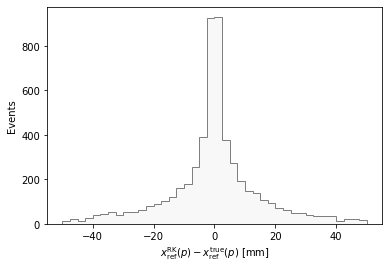

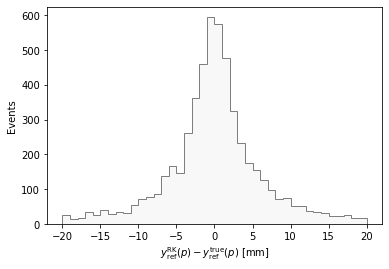

In [29]:
bias_boundary_dictionary = {
    'x': (-50,50),
    'y': (-20,20),
}

for comp in ['x', 'y']:
    reco_feature = 'p_AtTrueVtx_REFP_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()

    plot_args = {
        'axis_label': f'${comp}^\mathrm{{RK}}_\mathrm{{ref}}({proton_symbol}) - {comp}^\mathrm{{true}}_\mathrm{{ref}} ({proton_symbol})$ [mm]',
        'plot_title': 'Distance between proton reference point & true vertex\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_refpoint_residual_' + comp + file_suffix,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': False
    }

    plot_single_histogram(
        df_events[reco_feature] - df_events[true_feature],
        **plot_args)

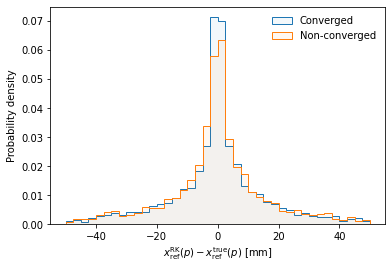

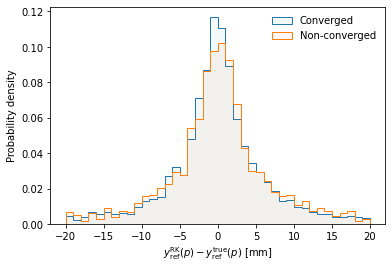

In [30]:
bias_boundary_dictionary = {
    'x': (-50,50),
    'y': (-20,20),
}

for comp in ['x', 'y']:
    reco_feature = 'p_AtTrueVtx_REFP_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()

    plot_args = {
        'axis_label': f'${comp}^\mathrm{{RK}}_\mathrm{{ref}}({proton_symbol}) - {comp}^\mathrm{{true}}_\mathrm{{ref}} ({proton_symbol})$ [mm]',
        'plot_title': 'Distance between proton reference point & true vertex\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_refpoint_residual_2Dv3D_' + comp + file_suffix,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': True
    }

    plot_2D_vs_3D_histograms(
        df_events,
        df_events[reco_feature] - df_events[true_feature],
        **plot_args)

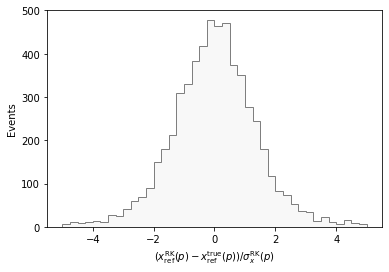

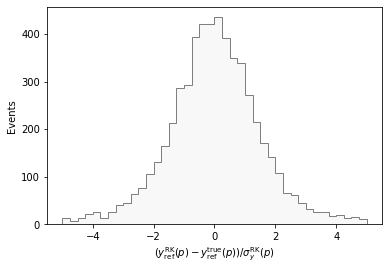

In [31]:
bias_boundary_dictionary = {
    'x': (-5,5),
    'y': (-5,5),
}

for comp in ['x', 'y']:
    reco_feature = 'p_AtTrueVtx_REFP_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()
    reco_error = 'p_AtTrueVtx_REFP_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': f'$({comp}^\mathrm{{RK}}_\mathrm{{ref}}({proton_symbol}) - {comp}^\mathrm{{true}}_\mathrm{{ref}} ({proton_symbol}))/\sigma_{comp}^\mathrm{{RK}} ({proton_symbol})$',
        'plot_title': 'Pulls between proton reference point & true vertex\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_refpoint_residual_' + comp + '_rel' + file_suffix,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': False
    }

    plot_single_histogram(
        (df_events[reco_feature] - df_events[true_feature])/df_events[reco_error],
        **plot_args)

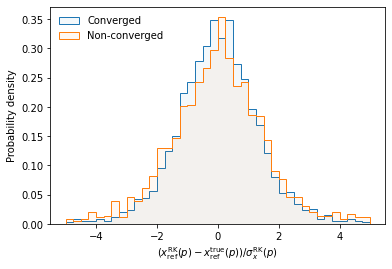

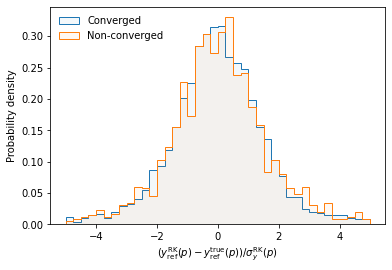

In [32]:
bias_boundary_dictionary = {
    'x': (-5,5),
    'y': (-5,5),
}

for comp in ['x', 'y']:
    reco_feature = 'p_AtTrueVtx_REFP_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()
    reco_error = 'p_AtTrueVtx_REFP_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': f'$({comp}^\mathrm{{RK}}_\mathrm{{ref}}({proton_symbol}) - {comp}^\mathrm{{true}}_\mathrm{{ref}} ({proton_symbol}))/\sigma_{comp}^\mathrm{{RK}} ({proton_symbol})$',
        'plot_title': 'Pulls between proton reference point & true vertex\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_refpoint_residual_2Dv3D_' + comp + '_rel' + file_suffix,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': True,
        'legend_loc': 'upper left'
    }

    plot_2D_vs_3D_histograms(
        df_events,
        (df_events[reco_feature] - df_events[true_feature])/df_events[reco_error],
        **plot_args)

## Pion reference point

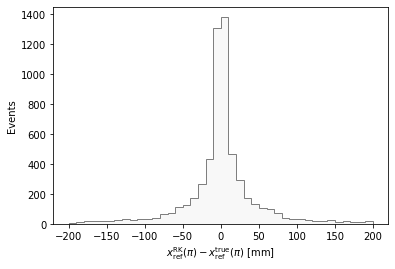

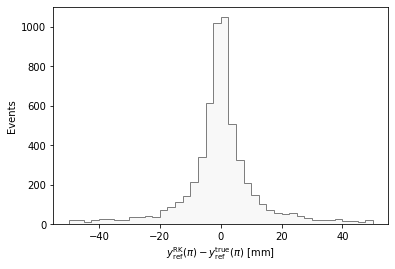

In [33]:
bias_boundary_dictionary = {
    'x': (-200,200),
    'y': (-50,50),
}

for comp in ['x', 'y']:
    reco_feature = 'pim_AtTrueVtx_REFP_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()

    plot_args = {
        'axis_label': f'${comp}^\mathrm{{RK}}_\mathrm{{ref}}({pion_symbol}) - {comp}^\mathrm{{true}}_\mathrm{{ref}} ({pion_symbol})$ [mm]',
        'plot_title': 'Distance between pion reference point & true vertex\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_refpoint_residual_' + comp + file_suffix,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': False
    }

    plot_single_histogram(
        df_events[reco_feature] - df_events[true_feature],
        **plot_args)

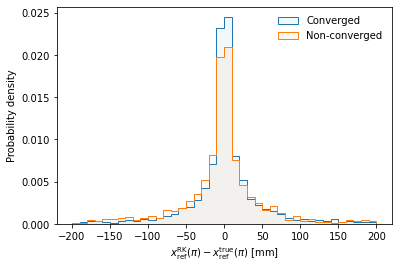

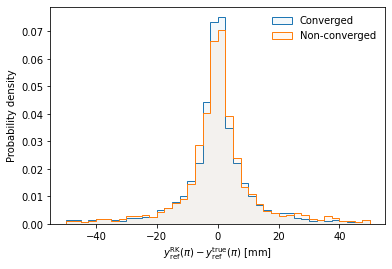

In [34]:
bias_boundary_dictionary = {
    'x': (-200,200),
    'y': (-50,50),
}

for comp in ['x', 'y']:
    reco_feature = 'pim_AtTrueVtx_REFP_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()

    plot_args = {
        'axis_label': f'${comp}^\mathrm{{RK}}_\mathrm{{ref}}({pion_symbol}) - {comp}^\mathrm{{true}}_\mathrm{{ref}} ({pion_symbol})$ [mm]',
        'plot_title': 'Distance between pion reference point & true vertex\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_refpoint_residual_2Dv3D_' + comp + file_suffix,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': True
    }

    plot_2D_vs_3D_histograms(
        df_events,
        df_events[reco_feature] - df_events[true_feature],
        **plot_args)

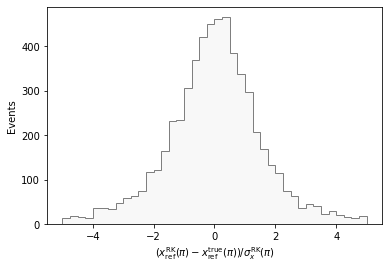

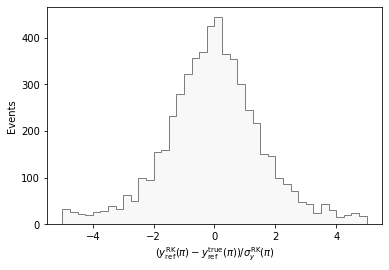

In [35]:
bias_boundary_dictionary = {
    'x': (-5,5),
    'y': (-5,5),
}

for comp in ['x', 'y']:
    reco_feature = 'pim_AtTrueVtx_REFP_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()
    reco_error = 'pim_AtTrueVtx_REFP_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': f'$({comp}^\mathrm{{RK}}_\mathrm{{ref}}({pion_symbol}) - {comp}^\mathrm{{true}}_\mathrm{{ref}} ({pion_symbol}))/\sigma_{comp}^\mathrm{{RK}} ({pion_symbol})$',
        'plot_title': 'Pulls between pion reference point & true vertex\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_refpoint_residual_' + comp + '_rel' + file_suffix,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': False
    }

    plot_single_histogram(
        (df_events[reco_feature] - df_events[true_feature])/df_events[reco_error],
        **plot_args)

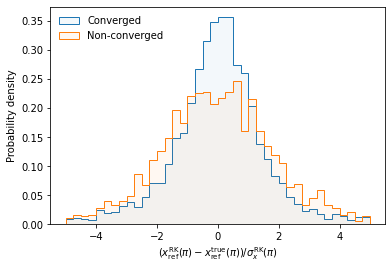

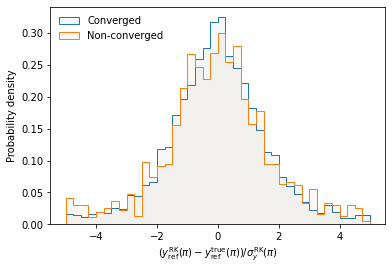

In [36]:
bias_boundary_dictionary = {
    'x': (-5,5),
    'y': (-5,5),
}

for comp in ['x', 'y']:
    reco_feature = 'pim_AtTrueVtx_REFP_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()
    reco_error = 'pim_AtTrueVtx_REFP_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': f'$({comp}^\mathrm{{RK}}_\mathrm{{ref}}({pion_symbol}) - {comp}^\mathrm{{true}}_\mathrm{{ref}} ({pion_symbol}))/\sigma_{comp}^\mathrm{{RK}} ({pion_symbol})$',
        'plot_title': 'Pulls between pion reference point & true vertex\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_refpoint_residual_2Dv3D_' + comp + '_rel' + file_suffix,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': True,
        'legend_loc': 'upper left'
    }

    plot_2D_vs_3D_histograms(
        df_events,
        (df_events[reco_feature] - df_events[true_feature])/df_events[reco_error],
        **plot_args)

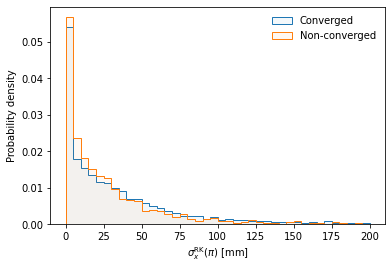

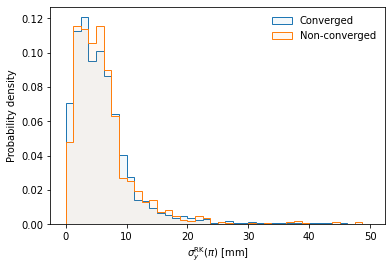

In [37]:
bias_boundary_dictionary = {
    'x': (0,200),
    'y': (0,50),
}

for comp in ['x', 'y']:
    reco_error = 'pim_AtTrueVtx_REFP_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': f'$\sigma_{comp}^\mathrm{{RK}} ({pion_symbol})$ [mm]',
        'plot_title': 'Uncertainty on pion reference point\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_refpoint_sigma_2Dv3D_' + comp + file_suffix,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': True
    }

    plot_2D_vs_3D_histograms(
        df_events,
        df_events[reco_error],
        **plot_args)

## Proton momentum


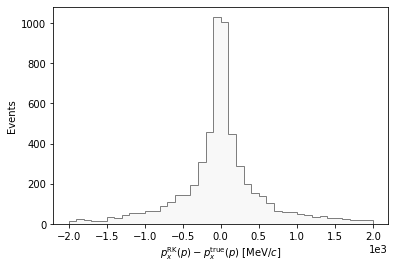

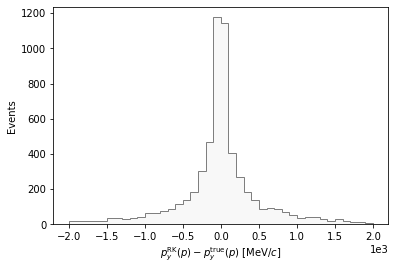

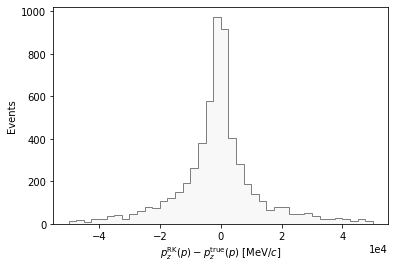

In [38]:
bias_boundary_dictionary = {
    'x': (-2e3,2e3),
    'y': (-2e3,2e3),
    'z': (-5e4,5e4)
}

for comp in ['x', 'y', 'z']:
    reco_feature = 'p_AtTrueVtx_P_' + comp.upper()
    true_feature = 'MCTRUTH_p_P' + comp.upper()

    plot_args = {
        'axis_label': f'$p^\mathrm{{RK}}_{comp}({proton_symbol}) - p^\mathrm{{true}}_{comp}({proton_symbol})$ [MeV/$c$]',
        'plot_title': 'Difference between proton reco & true momenta\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_momentum_residual_' + comp + file_suffix,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': False
    }

    plot_single_histogram(
        df_events[reco_feature] - df_events[true_feature],
        **plot_args)

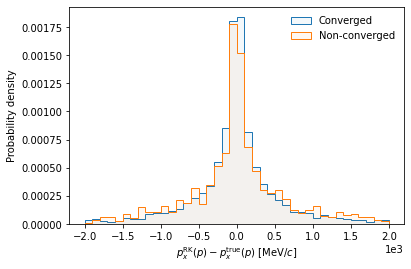

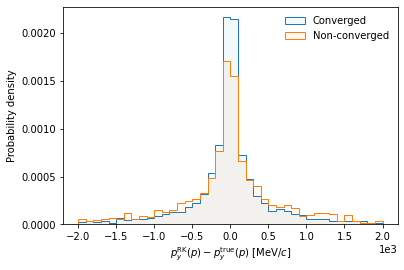

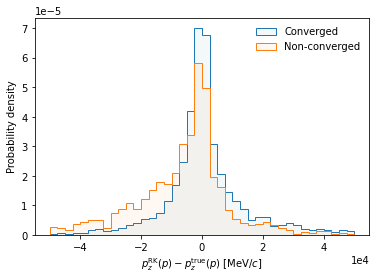

In [39]:
bias_boundary_dictionary = {
    'x': (-2e3,2e3),
    'y': (-2e3,2e3),
    'z': (-5e4,5e4)
}

for comp in ['x', 'y', 'z']:
    reco_feature = 'p_AtTrueVtx_P_' + comp.upper()
    true_feature = 'MCTRUTH_p_P' + comp.upper()

    plot_args = {
        'axis_label': f'$p^\mathrm{{RK}}_{comp}({proton_symbol}) - p^\mathrm{{true}}_{comp}({proton_symbol})$ [MeV/$c$]',
        'plot_title': 'Difference between proton reco & true momenta\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_momentum_residual_2Dv3D_' + comp + file_suffix,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': True
    }

    plot_2D_vs_3D_histograms(
        df_events,
        df_events[reco_feature] - df_events[true_feature],
        **plot_args)

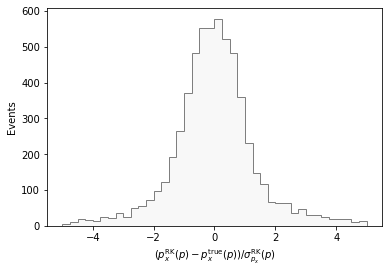

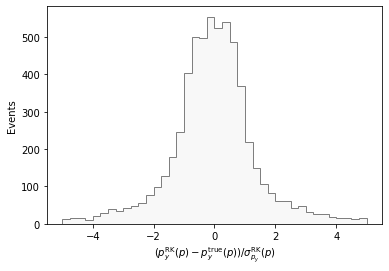

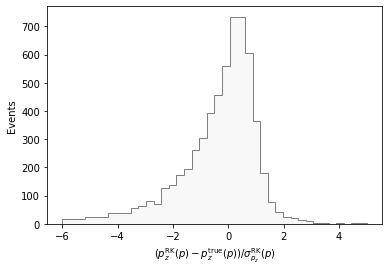

In [40]:
bias_boundary_dictionary = {
    'x': (-5,5),
    'y': (-5,5),
    'z': (-6,5)
}

for comp in ['x', 'y', 'z']:
    reco_feature = 'p_AtTrueVtx_P_' + comp.upper()
    true_feature = 'MCTRUTH_p_P' + comp.upper()
    reco_error = 'p_AtTrueVtx_P_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': f'$(p^\mathrm{{RK}}_{comp}({proton_symbol}) - p^\mathrm{{true}}_{comp}({proton_symbol})) / \sigma_{{p_{comp}}}^\mathrm{{RK}} ({proton_symbol})$',
        'plot_title': 'Pulls between proton reco & true momenta\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_momentum_residual_' + comp + '_rel' + file_suffix,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': False
    }

    plot_single_histogram(
        (df_events[reco_feature] - df_events[true_feature])/df_events[reco_error],
        **plot_args)

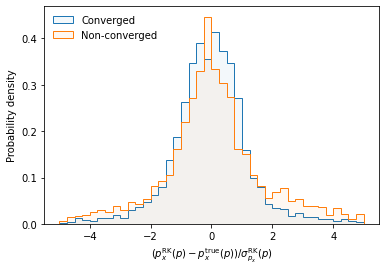

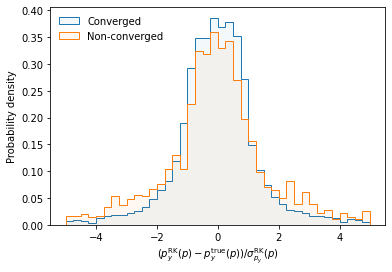

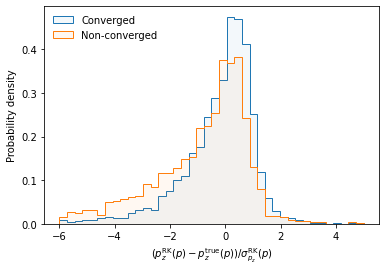

In [41]:
bias_boundary_dictionary = {
    'x': (-5,5),
    'y': (-5,5),
    'z': (-6,5)
}

for comp in ['x', 'y', 'z']:
    reco_feature = 'p_AtTrueVtx_P_' + comp.upper()
    true_feature = 'MCTRUTH_p_P' + comp.upper()
    reco_error = 'p_AtTrueVtx_P_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': f'$(p^\mathrm{{RK}}_{comp}({proton_symbol}) - p^\mathrm{{true}}_{comp}({proton_symbol})) / \sigma_{{p_{comp}}}^\mathrm{{RK}} ({proton_symbol})$',
        'plot_title': 'Pulls between proton reco & true momenta\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_momentum_residual_2Dv3D_' + comp + '_rel' + file_suffix,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': True,
        'legend_loc': 'upper left'
    }

    plot_2D_vs_3D_histograms(
        df_events,
        (df_events[reco_feature] - df_events[true_feature])/df_events[reco_error],
        **plot_args)

## Pion momentum

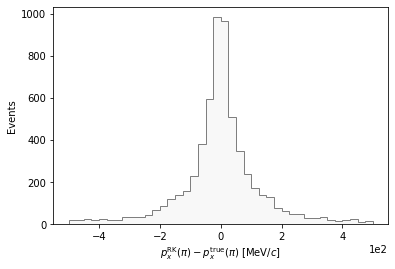

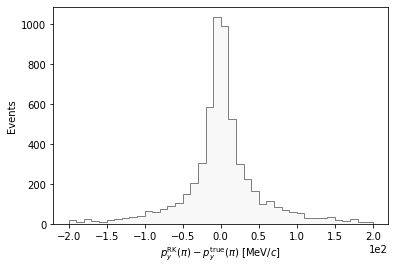

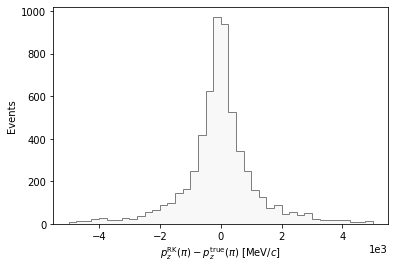

In [42]:
bias_boundary_dictionary = {
    'x': (-5e2,5e2),
    'y': (-2e2,2e2),
    'z': (-5e3,5e3)
}

for comp in ['x', 'y', 'z']:
    reco_feature = 'pim_AtTrueVtx_P_' + comp.upper()
    true_feature = 'MCTRUTH_pim_P' + comp.upper()

    plot_args = {
        'axis_label': f'$p^\mathrm{{RK}}_{comp}({pion_symbol}) - p^\mathrm{{true}}_{comp}({pion_symbol})$ [MeV/$c$]',
        'plot_title': 'Difference between pion reco & true momenta\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_momentum_residual_' + comp + file_suffix,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': False
    }

    plot_single_histogram(
        df_events[reco_feature] - df_events[true_feature],
        **plot_args)

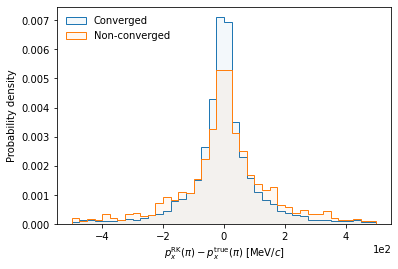

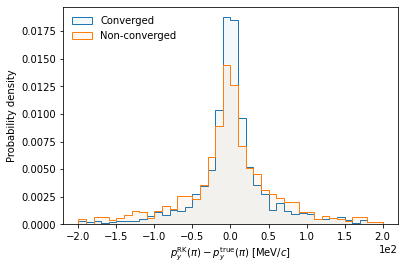

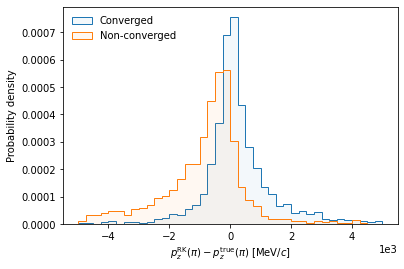

In [43]:
bias_boundary_dictionary = {
    'x': (-5e2,5e2),
    'y': (-2e2,2e2),
    'z': (-5e3,5e3)
}

for comp in ['x', 'y', 'z']:
    reco_feature = 'pim_AtTrueVtx_P_' + comp.upper()
    true_feature = 'MCTRUTH_pim_P' + comp.upper()

    plot_args = {
        'axis_label': f'$p^\mathrm{{RK}}_{comp}({pion_symbol}) - p^\mathrm{{true}}_{comp}({pion_symbol})$ [MeV/$c$]',
        'plot_title': 'Difference between pion reco & true momenta\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_momentum_residual_2Dv3D_' + comp + file_suffix,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': True,
        'legend_loc': 'upper left'
    }

    plot_2D_vs_3D_histograms(
        df_events,
        df_events[reco_feature] - df_events[true_feature],
        **plot_args)

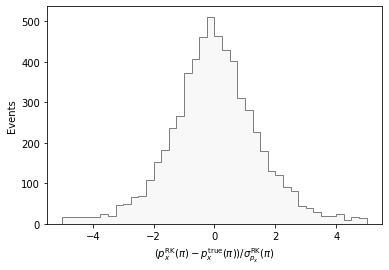

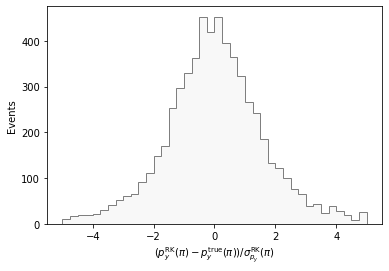

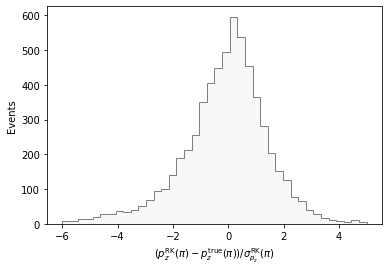

In [44]:
bias_boundary_dictionary = {
    'x': (-5,5),
    'y': (-5,5),
    'z': (-6,5)
}

for comp in ['x', 'y', 'z']:
    reco_feature = 'pim_AtTrueVtx_P_' + comp.upper()
    true_feature = 'MCTRUTH_pim_P' + comp.upper()
    reco_error = 'pim_AtTrueVtx_P_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': f'$(p^\mathrm{{RK}}_{comp}({pion_symbol}) - p^\mathrm{{true}}_{comp}({pion_symbol})) / \sigma_{{p_{comp}}}^\mathrm{{RK}} ({pion_symbol})$',
        'plot_title': 'Pulls between pion reco & true momenta\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_momentum_residual_' + comp + '_rel' + file_suffix,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': False
    }

    plot_single_histogram(
        (df_events[reco_feature] - df_events[true_feature])/df_events[reco_error],
        **plot_args)

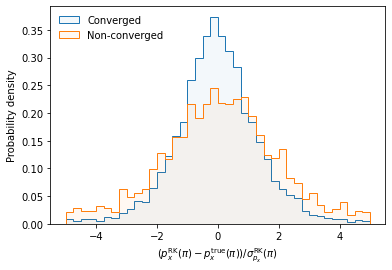

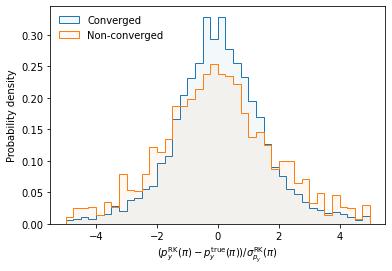

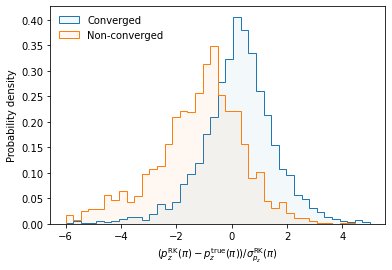

In [45]:
bias_boundary_dictionary = {
    'x': (-5,5),
    'y': (-5,5),
    'z': (-6,5)
}

for comp in ['x', 'y', 'z']:
    reco_feature = 'pim_AtTrueVtx_P_' + comp.upper()
    true_feature = 'MCTRUTH_pim_P' + comp.upper()
    reco_error = 'pim_AtTrueVtx_P_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': f'$(p^\mathrm{{RK}}_{comp}({pion_symbol}) - p^\mathrm{{true}}_{comp}({pion_symbol})) / \sigma_{{p_{comp}}}^\mathrm{{RK}} ({pion_symbol})$',
        'plot_title': 'Pulls between pion reco & true momenta\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_momentum_residual_2Dv3D_' + comp + '_rel' + file_suffix,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': True,
        'legend_loc': 'upper left'
    }

    plot_2D_vs_3D_histograms(
        df_events,
        (df_events[reco_feature] - df_events[true_feature])/df_events[reco_error],
        **plot_args)

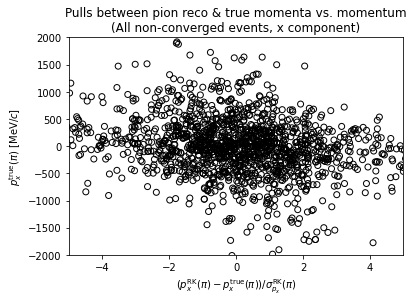

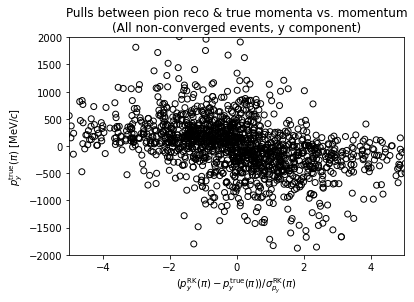

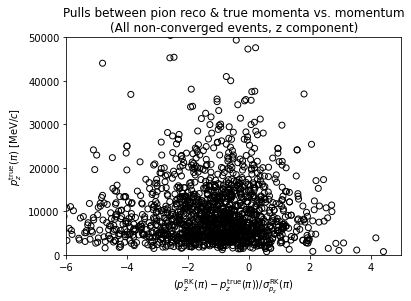

In [46]:
bias_boundary_dictionary = {
    'x': (-5,5),
    'y': (-5,5),
    'z': (-6,5)
}

momentum_boundary_dictionary = {
    'x': (-2000,2000),
    'y': (-2000,2000),
    'z': (0,5e4)    
}

is_VF = df_events['L_ALGO_ID'] == 'VertexFitter'

for comp in ['x', 'y', 'z']:
    reco_feature = 'pim_AtTrueVtx_P_' + comp.upper()
    true_feature = 'MCTRUTH_pim_P' + comp.upper()
    reco_error = 'pim_AtTrueVtx_P_' + comp.upper() + 'ERR'
    
    plt.scatter(
        (df_events.loc[~is_VF, reco_feature] - df_events.loc[~is_VF, true_feature])/df_events.loc[~is_VF, reco_error],
        df_events.loc[~is_VF, true_feature],
        marker='o',
        facecolor='none',
        edgecolor='k'
    )
    plt.xlim(bias_boundary_dictionary[comp])
    plt.ylim(momentum_boundary_dictionary[comp])
    plt.xlabel(f'$(p^\mathrm{{RK}}_{comp}({pion_symbol}) - p^\mathrm{{true}}_{comp}({pion_symbol})) / \sigma_{{p_{comp}}}^\mathrm{{RK}} ({pion_symbol})$')
    plt.ylabel(f'$p^\mathrm{{true}}_{comp}({pion_symbol})$ [MeV/$c$]')
    plt.title('Pulls between pion reco & true momenta vs. momentum\n(' + recovered_label + ', ' + comp + " component)")
    if save_plots:
        plt.savefig(plots_dir + fn_prefix + 'pim_mom_res_vs_mom_2D_scatter_' + comp + file_suffix + '.pdf', bbox_inches='tight')
    plt.show()

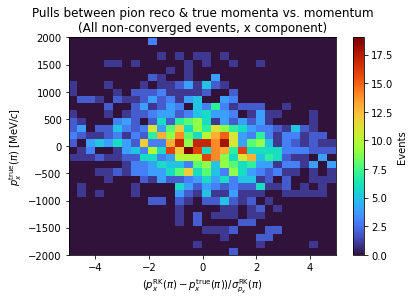

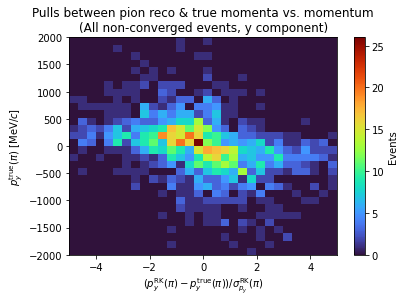

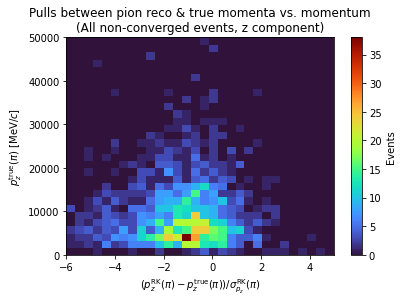

In [47]:
bias_boundary_dictionary = {
    'x': (-5,5),
    'y': (-5,5),
    'z': (-6,5)
}

momentum_boundary_dictionary = {
    'x': (-2000,2000),
    'y': (-2000,2000),
    'z': (0,5e4)    
}

is_VF = df_events['L_ALGO_ID'] == 'VertexFitter'

for comp in ['x', 'y', 'z']:
    reco_feature = 'pim_AtTrueVtx_P_' + comp.upper()
    true_feature = 'MCTRUTH_pim_P' + comp.upper()
    reco_error = 'pim_AtTrueVtx_P_' + comp.upper() + 'ERR'
    
    plt.hist2d(
        (df_events.loc[~is_VF, reco_feature] - df_events.loc[~is_VF, true_feature])/df_events.loc[~is_VF, reco_error],
        df_events.loc[~is_VF, true_feature],
        range=[bias_boundary_dictionary[comp], momentum_boundary_dictionary[comp]],
        bins=30,
        cmap='turbo'
    )
    plt.xlabel(f'$(p^\mathrm{{RK}}_{comp}({pion_symbol}) - p^\mathrm{{true}}_{comp}({pion_symbol})) / \sigma_{{p_{comp}}}^\mathrm{{RK}} ({pion_symbol})$')
    plt.ylabel(f'$p^\mathrm{{true}}_{comp}({pion_symbol})$ [MeV/$c$]')
    plt.title('Pulls between pion reco & true momenta vs. momentum\n(' + recovered_label + ', ' + comp + " component)")
    plt.colorbar(label='Events')
    if save_plots:
        plt.savefig(plots_dir + fn_prefix + 'pim_mom_res_vs_mom_2D_hist2d_' + comp + file_suffix + '.pdf', bbox_inches='tight')
    plt.show()

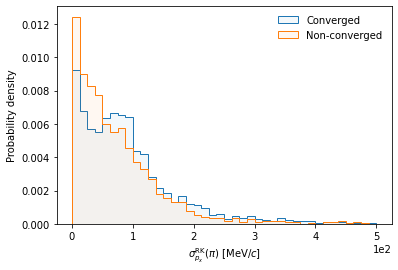

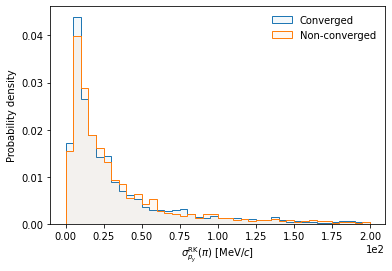

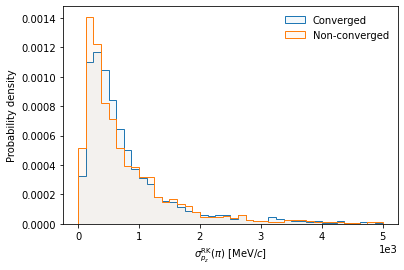

In [48]:
bias_boundary_dictionary = {
    'x': (0,5e2),
    'y': (0,2e2),
    'z': (0,5e3)
}

for comp in ['x', 'y', 'z']:
    reco_error = 'pim_AtTrueVtx_P_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': f'$\sigma_{{p_{comp}}}^\mathrm{{RK}} ({pion_symbol})$ [MeV/$c$]',
        'plot_title': 'Uncertainty on pion momentum\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_momentum_sigma_2Dv3D_' + comp + file_suffix,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': True
    }

    plot_2D_vs_3D_histograms(
        df_events,
        df_events[reco_error],
        **plot_args)

# Sanity check: are DTF momenta the same as the sum of their daughters?
Unfortunately, DTF momenta are only given in modulus. That's the only check we can do.

In [49]:
df_events['DTF_FixJPsiLambda_mum_PX']

0       2336.726807
1       5243.780273
2      -1195.397583
3       -161.569580
4      -3774.639160
           ...     
6329     842.880310
6330    6067.042969
6331    -174.674118
6332   -1181.296631
6333   -2677.654541
Name: DTF_FixJPsiLambda_mum_PX, Length: 6334, dtype: float32

In [50]:
prefix = 'DTF_FixJPsiLambda_'
particle = 'L'
daughter_1 = 'p'
daughter_2 = 'pim'

for comp in ['X', 'Y', 'Z']:
    df_events[prefix + particle + '_P' + comp] = df_events[prefix + daughter_1 + '_P' + comp] + df_events[prefix + daughter_2 + '_P' + comp]

particle = 'Jpsi'
daughter_1 = 'mum'
daughter_2 = 'mup'

for comp in ['X', 'Y', 'Z']:
    df_events[prefix + particle + '_P' + comp] = df_events[prefix + daughter_1 + '_P' + comp] + df_events[prefix + daughter_2 + '_P' + comp]
    
particle = 'Lb'
daughter_1 = 'L'
daughter_2 = 'Jpsi'

for comp in ['X', 'Y', 'Z']:
    df_events[prefix + particle + '_P' + comp] = df_events[prefix + daughter_1 + '_P' + comp] + df_events[prefix + daughter_2 + '_P' + comp]

In [51]:
prefix = 'DTF_FixJPsiLambda_'
particle = 'L'
daughter_1 = 'p'
daughter_2 = 'pim'

p_from_dtf = df_events[prefix + particle + '_P']
p_from_daughters = np.sqrt(
    df_events[prefix + particle + '_PX']**2
    + df_events[prefix + particle + '_PY']**2
    + df_events[prefix + particle + '_PZ']**2)

In [52]:
df_events['L_ALGO_ID']

0       VertexFitter
1       VertexFitter
2       VertexFitter
3       NonConverged
4       VertexFitter
            ...     
6329    NonConverged
6330    NonConverged
6331    VertexFitter
6332    NonConverged
6333    VertexFitter
Name: L_ALGO_ID, Length: 6334, dtype: object

In [53]:
(p_from_dtf - p_from_daughters).loc[df_events['L_ALGO_ID'] == 'VertexFitter']

0       0.000000
1       0.000000
2       0.000000
4       0.003906
5       0.007812
          ...   
6326    0.000000
6327    0.003906
6328    0.000000
6331    0.003906
6333    0.000000
Length: 4593, dtype: float32

In [54]:
(p_from_dtf - p_from_daughters).loc[df_events['L_ALGO_ID'] == 'XBlownUpAlgorithm']

Series([], dtype: float32)

In [55]:
(p_from_dtf - p_from_daughters).loc[df_events['L_ALGO_ID'] == 'YBlownUpAlgorithm']

Series([], dtype: float32)

In [56]:
(p_from_dtf - p_from_daughters).loc[df_events['L_ALGO_ID'] == 'ZBlownUpAlgorithm']

Series([], dtype: float32)

Yeah, DTF momenta are computed by summing the daughters, I think that's pretty obvious. Even accounting for $p_z$ taking a large chunk of $p$, that's way too many matching digits. Doesn't care about the algorithm either.

In [57]:
prefix = 'DTF_FixJPsiLambda_'
particle = 'Lb'
daughter_1 = 'JPsi'
daughter_2 = 'L'

p_from_dtf = df_events[prefix + particle + '_P']
p_from_daughters = np.sqrt(
    df_events[prefix + particle + '_PX']**2
    + df_events[prefix + particle + '_PY']**2
    + df_events[prefix + particle + '_PZ']**2)

In [58]:
p_from_dtf - p_from_daughters

0       0.000000
1       0.000000
2      -0.007812
3      -0.007812
4      -0.007812
          ...   
6329    0.000000
6330    0.007812
6331    0.000000
6332    0.007812
6333    0.000000
Length: 6334, dtype: float32

Not as straightforwardly 0 here (after all, there's more steps involved), but still pretty satisfying.

In [59]:
df_events['L_ALGO_ID'].value_counts()

VertexFitter    4593
NonConverged    1741
Name: L_ALGO_ID, dtype: int64